In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Optional

In [3]:
def draw_image(
        matrix: np.array, 
        m: int = 256, 
        image_size: int =512, 
        d: int = 2, 
        filename: str = "", 
        popout: bool = False, 
        save_gif: bool = False
) -> Optional[Image]:
    
    image = Image.new(mode="RGB", color=(0, 0, 0), size=(image_size, image_size))
    for i in range(m):
        for j in range(m):
            color = (0, 0, 0) if matrix[i, j] else (255, 255, 255)
            for k in range(i*d, i*d + d):
                for l in range(j*d, j*d + d):
                    image.putpixel((k, l), color)

    if popout:
        image.show()
    if filename:
        image.save(f"binary_pictures/{filename}")
    if save_gif:
        return image
    display(image)


def plot_energy(energy: list[float]) -> None:
    plt.plot([i for i in range(len(energy))], energy)
    plt.title("Energy levels")
    plt.show()


def plot_temperature(temperature: list[float]) -> None:
    plt.plot([i for i in range(len(temperature))], temperature)
    plt.title("Temperature function")
    plt.show()

In [4]:
def prepare_image(matrix: np.array, m: int, density: float) -> None:
    for i in range(m):
        for j in range(m):
            matrix[i, j] = 1 if np.random.rand() < density else 0

### Neighborhood generation

Transitioning from one state to another in each case means swapping the positions of two different pixels. Two colors can be swapped in a given iteration if they are adjacent. A total of 6 types of neighborhoods are defined:



In [9]:
changes_t = tuple[tuple[int, int], tuple[int, int]]

def neighbor1(matrix: np.array) -> Optional[changes_t]:
    """
    Pixel might swap with pixel directly below or to the right of it
        X X
        X
    """
    m = matrix.shape[0]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = 0, 0
    if np.random.randint(0, 2):
        x_d = 1
    else:
        y_d = 1
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None


def neighbor2(matrix: np.array) -> Optional[changes_t]:
    """
    Pixel might swap with pixel directly below, above, to the left or to the right
        X
      X X X
        X
    """
    m = matrix.shape[0]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = 0, 0
    if np.random.randint(0, 2):
        x_d = 1 if np.random.randint(0, 2) else -1
    else:
        y_d = 1 if np.random.randint(0, 2) else -1
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None


def neighbor3(matrix: np.array) -> Optional[changes_t]:
    """
    Pixel might swap with any adjacent pixel
       X X X
       X X X
       X X X
    """
    m = matrix.shape[0]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = np.random.randint(-1, 2), np.random.randint(-1, 2)
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None


def neighbor4(matrix: np.array) -> Optional[changes_t]:
    """
    Pixel might swap with any corner
        X   X
          X
        X   X
    """
    m = matrix.shape[0]
    t = [-1, 1]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = t[np.random.randint(0, 2)], t[np.random.randint(0, 2)]
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None


def neighbor5(matrix: np.array) -> Optional[changes_t]:
    """
    Only up and down
        X
        X
        X
    """
    m = matrix.shape[0]
    t = [-1, 1]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = t[np.random.randint(0, 2)], 0
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None



def neighbor6(matrix: np.array) -> Optional[changes_t]:
    """    
    Only diagonal
            X
         X
      X
    """
    m = matrix.shape[0]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = (1, -1) if np.random.randint(0, 2) else (-1, 1)
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None

### Objective functions to minimize


The energy of the entire system is the sum of the energies of individual cells. In each case, I calculate the energy for a single cell in the same way. I define a function d(x,y) that is symmetric, meaning d(x,y)=d(y,x). For a given cell, I then calculate the sum of the values of this function for that specific cell and its neighbors. The types of neighborhoods are analogous to those described above, although there are situations where, for example, swapping cells involves exchanging pixels from the same column. When calculating the energy for a given cell, I consider all 8 adjacent cells.

In [6]:
def cell_energy1(matrix: np.array, x: int, y: int) -> int:
    """
        Four neighbors, energy is the sum of values of the bitwise XOR of the central pixel and its neighbors.
        In practice, for any white cell, this function counts the number of black cells and vice versa.
    """
    energy = 0
    energy += matrix[x, y] ^ matrix[x, y+1]
    energy += matrix[x, y] ^ matrix[x+1, y]
    energy += matrix[x, y] ^ matrix[x, y-1]
    energy += matrix[x, y] ^ matrix[x-1, y]
    return energy


def cell_energy2(matrix: np.array, x: int, y: int) -> int:
    """
        XOR swapped to XNOR
    """
    energy = 0
    energy += not(matrix[x, y] ^ matrix[x, y+1])
    energy += not(matrix[x, y] ^ matrix[x+1, y])
    energy += not(matrix[x, y] ^ matrix[x, y-1])
    energy += not(matrix[x, y] ^ matrix[x-1, y])
    return energy


def cell_energy3(matrix: np.array, x: int, y: int) -> int:
    """
        XOR swapped to AND.
        In practice all white cells have energy zero.
        Black cells count surrounding black cells.
    """
    energy = 0
    energy += matrix[x, y] & matrix[x, y+1]
    energy += matrix[x, y] & matrix[x+1, y]
    energy += matrix[x, y] & matrix[x, y-1]
    energy += matrix[x, y] & matrix[x-1, y]
    return energy


def cell_energy4(matrix: np.array, x: int, y: int) -> int:
    """
        Same as the first but all adjacent cent are involved
    """
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            energy += matrix[x, y] ^ matrix[x+i, y+j]
    return energy


def cell_energy5(matrix: np.array, x: int, y: int) -> int:
    """
        Same as the third but all adjacent cent are involved
    """
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            energy += matrix[x, y] & matrix[x+i, y+j]
    return energy - matrix[x, y]


def cell_energy6(matrix: np.array, x: int, y: int) -> int:
    """
        XOR and only corners are involved
    """
    energy = 0
    t = [-1, 1]
    for i in t:
        for j in t:
            energy += matrix[x, y] ^ matrix[x+i, y+j]
    return energy


def cell_energy7(matrix: np.array, x: int, y: int) -> int:
    """
        AND and only corners are involved
    """
    energy = 0
    t = [-1, 1]
    for i in t:
        for j in t:
            energy += matrix[x, y] & matrix[x+i, y+j]
    return energy

In [10]:
def calc_diff(matrix: np.array, changes: changes_t, cell_energy: callable) -> int:
    """
        Calculate energy change after swap
    """
    p1, p2 = changes
    before = cell_energy(matrix, p1[0], p1[1]) + cell_energy(matrix, p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(matrix, p1[0], p1[1]) + cell_energy(matrix, p2[0], p2[1])
    return 2*(after - before)


def revert(matrix: np.array, changes: changes_t):
    """
        Revert changes
    """
    s1, s2 = changes
    matrix[s1[0], s1[1]], matrix[s2[0], s2[1]] = matrix[s2[0], s2[1]] , matrix[s1[0], s1[1]]

In [11]:
def calculate_initial_energy(matrix: np.array, single_cell_energy: callable) -> int:
    m = matrix.shape[0]
    energy = 0
    for i in range(1, m - 1):
        for j in range(1, m - 1):
            energy += single_cell_energy(matrix, i, j)
    return energy

### Annealing

Similarly to traveling salesman problem, the function calculating the probability is 
$exp{\frac{-\Delta}{T}} $, where $\Delta$ is the change in energy when transitioning to a neighboring state, and 
$T$ is the temperature. The temperature decays exponentially, but due to the large number of iterations, the ratio in this case is a number in the range (0.999 - 0.9999). Parameters that produced the most interesting results in most cases were 50,000 steps, and for a fixed temperature level, I additionally performed 100 iterations of the neighbor-finding algorithm.

In [12]:
def annealing(
        matrix: np.array, 
        swap: callable, 
        cell_energy: callable, 
        alpha: float = 0.9999, 
        T0: float = 5, 
        steps: int = 50000, 
        no_of_iter: int = 100, 
        filename: str = "", 
        save_gif: bool = False
) -> None:
    
    T = T0
    temperature = [T]
    cur_energy = calculate_initial_energy(matrix, cell_energy)
    energy_states = [cur_energy]
    for i in range(steps):
        for j in range(no_of_iter):
            changes = swap(matrix)
            if changes is None:
                continue
            delta = calc_diff(matrix, changes, cell_energy)
            if delta < 0:
                cur_energy += delta
            else:
                if np.exp((-delta) / T) > np.random.uniform(0, 1):
                    cur_energy += delta
                else:
                    revert(matrix, changes)
            energy_states.append(cur_energy)
        if i % 500 == 0 and save_gif:
            print(steps)
            frames.append(draw_image(matrix, save_gif=True))
        T *= alpha
        temperature.append(T)
    draw_image(matrix, filename=filename)
    plot_energy(energy_states)
    plot_temperature(temperature)

I will conduct tests for the following densities of black points:
0.1; 0.3; 0.5; 0.7

In [10]:
densities = [0.1, 0.3, 0.5, 0.7]

In [9]:
def make_test(neighbor, cell_energy, save_gif=False, m=256, dens=0.5):
    matrix = np.zeros((m, m), dtype=int)
    prepare_image(matrix, m, dens)
    draw_image(matrix)
    annealing(deepcopy(matrix), neighbor, cell_energy, save_gif=save_gif)

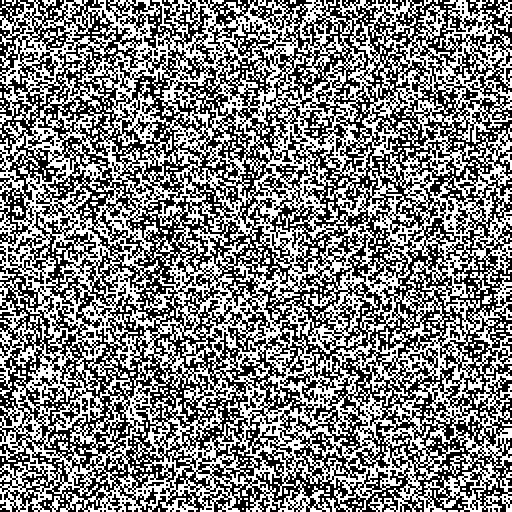

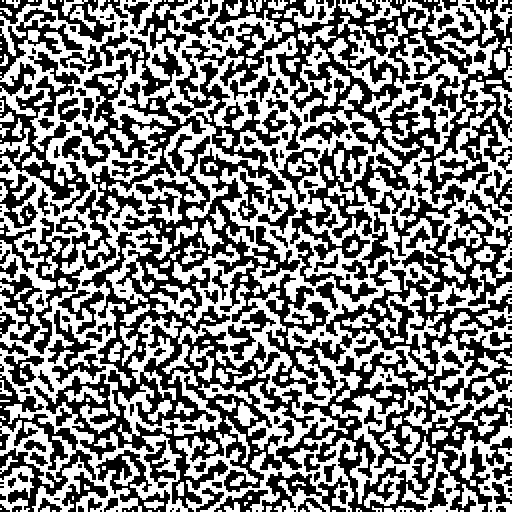

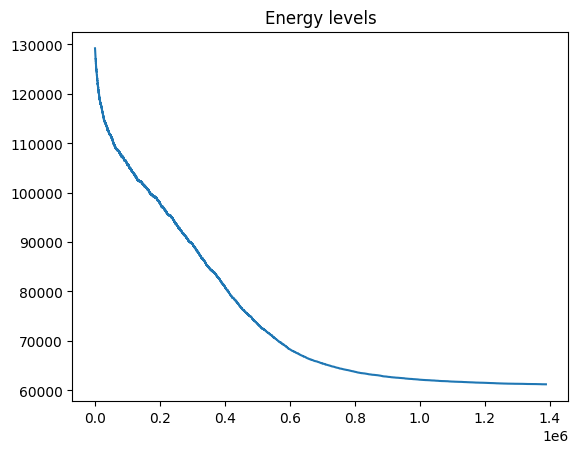

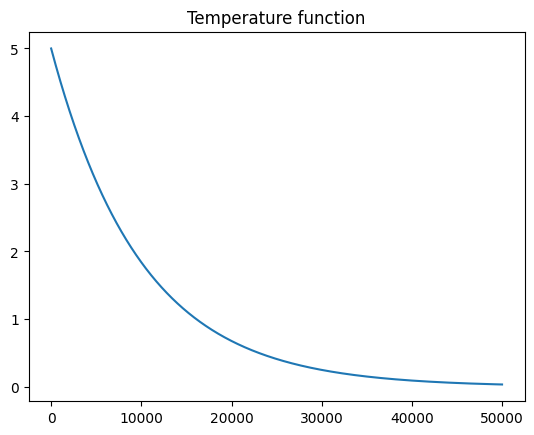

In [15]:
make_test(neighbor1, cell_energy1)

The energy level plot does not indicate that the annealing process is occurring. However, the energy changes when transitioning from state to state are typically less than 10, while the initial energy of the system is around 130,000, so plots looks differently than in typical annealing. Below are the plots for running the same program but without the probability of jumping to a higher energy state like in the standard annealing algorithm.

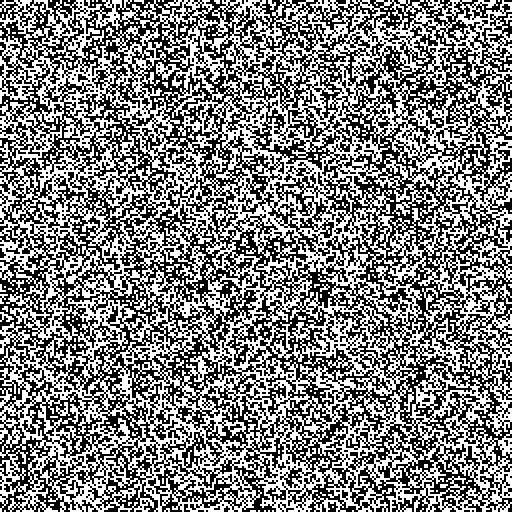

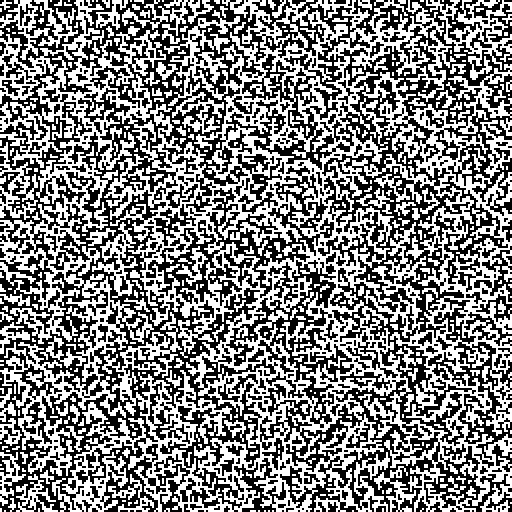

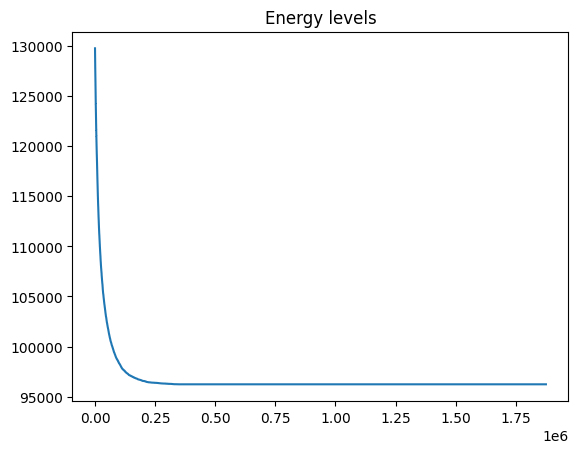

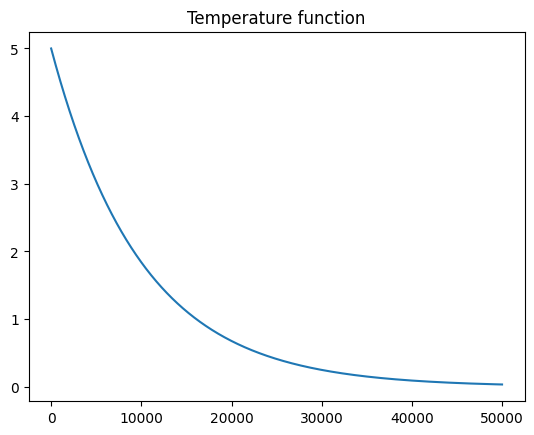

In [17]:
make_test(neighbor1, cell_energy1)

It's clear to see that the process got stuck in a local minimum after just a few iterations, and the final energy was almost 30,000 higher than with annealing.

#### Visualisation of successive steps of the process

In [ ]:
frames = []
make_test(neighbor2, cell_energy5, save_gif=True)
frame_one = frames[0]
frame_one.save("annealing_gifs/binary1.gif", format="GIF", append_images=frames,
                   save_all=True, duration=100, loop=0)

<img src="annealing_gifs/binary1.gif" width="500" align="center">

In [ ]:
frames = []
make_test(neighbor1, cell_energy6, dens=0.1, save_gif=True)
frame_one = frames[0]
frame_one.save("annealing_gifs/binary2.gif", format="GIF", append_images=frames,
                   save_all=True, duration=100, loop=0)

<img src="annealing_gifs/binary2.gif" width="500" align="center">

Examples of calls for several selected energy functions and neighbor generation functions. For each pair (neighbor generation function, energy function), I check the call for the 4 densities mentioned above. The same images are located in the binary_pictures folder. The images are sized 512 x 512, where 256 refers to the number of cells in the matrix, and each cell occupies 4 pixels.

In [170]:
tuples_to_test = [(neighbor1, cell_energy1), (neighbor1, cell_energy5), (neighbor1, cell_energy6), (neighbor1, cell_energy7), (neighbor2, cell_energy5),
                  (neighbor3, cell_energy4), (neighbor4, cell_energy2), (neighbor5, cell_energy7), (neighbor6, cell_energy4)]

descriptors = [(1, 1), (1, 5), (1, 6), (1, 7), (2, 5), (3, 4), (4, 2), (5, 7), (6, 4)]

In [13]:
def count_pixels(matrix: np.array, image_size: int) -> tuple[int, int]:
    count1, count2 = 0, 0
    for i in range(image_size):
        for j in range(image_size):
            if matrix[i, j] == 0:
                count1 += 1
            elif matrix[i, j] == 1:
                count2 += 1
    return count1, count2

In [13]:
def make_tests():
    for dens in densities:
        m = 256
        matrix = np.zeros((m, m), dtype=int)
        prepare_image(matrix, m, dens)
        draw_image(matrix, filename=f"before_annealing_density_{int(dens*10)}_size{256}.png", popout=True)
        for (neighbor, cell_energy), (n, c) in zip(tuples_to_test, descriptors):
            f_name = f"after_neighbor_{n}_function_{c}_density_{int(dens*10)}_size_{256}.png"
            print(f_name)
            annealing(deepcopy(matrix), neighbor, cell_energy, filename=f_name)
            print()
            print()


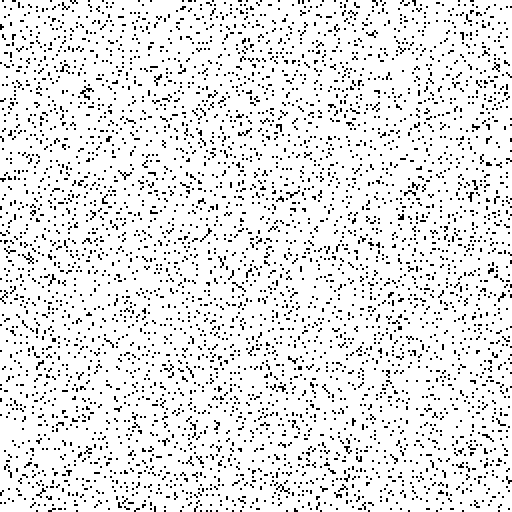

after_neighbor_1_function_1_density_1_size_256.png


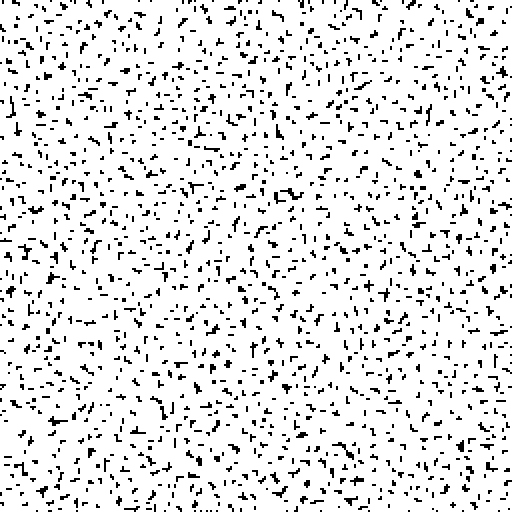



after_neighbor_1_function_5_density_1_size_256.png


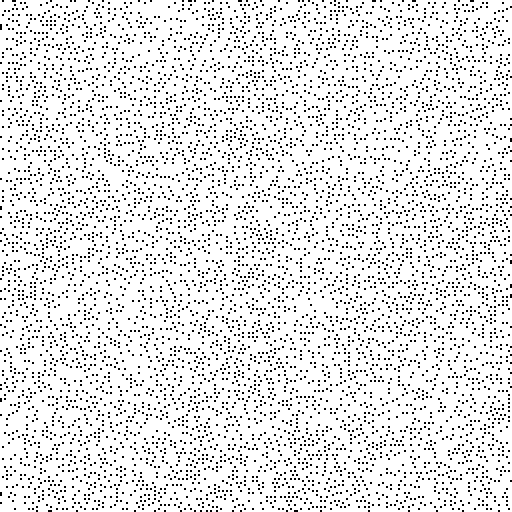



after_neighbor_1_function_6_density_1_size_256.png


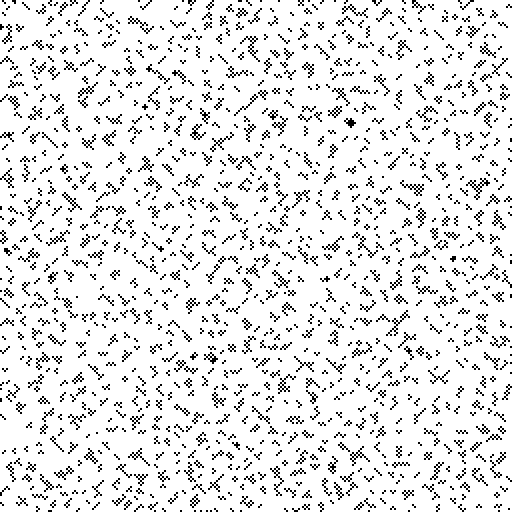



after_neighbor_1_function_7_density_1_size_256.png


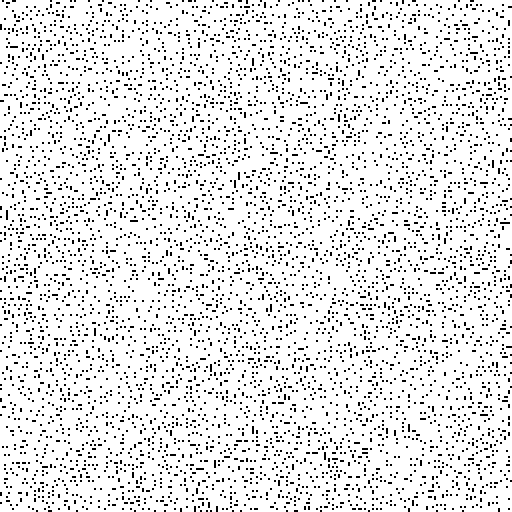



after_neighbor_2_function_5_density_1_size_256.png


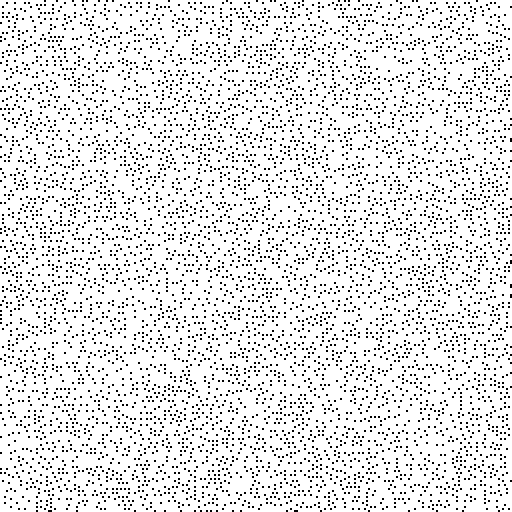



after_neighbor_3_function_4_density_1_size_256.png


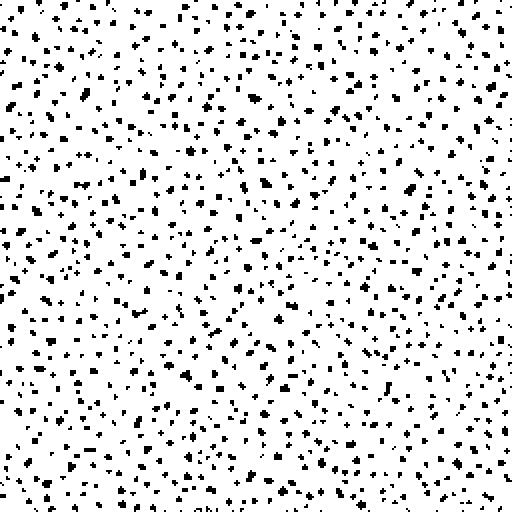



after_neighbor_4_function_2_density_1_size_256.png


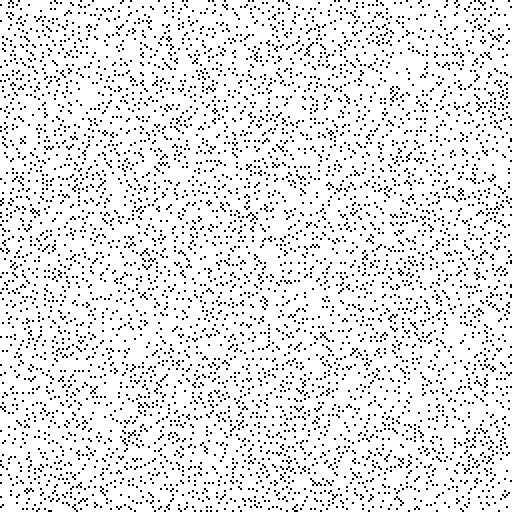



after_neighbor_5_function_7_density_1_size_256.png


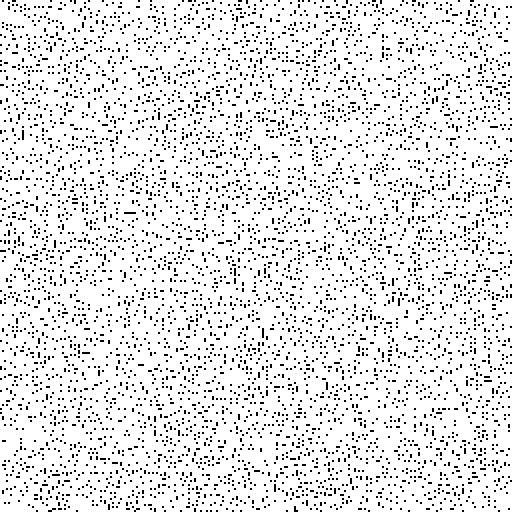



after_neighbor_6_function_4_density_1_size_256.png


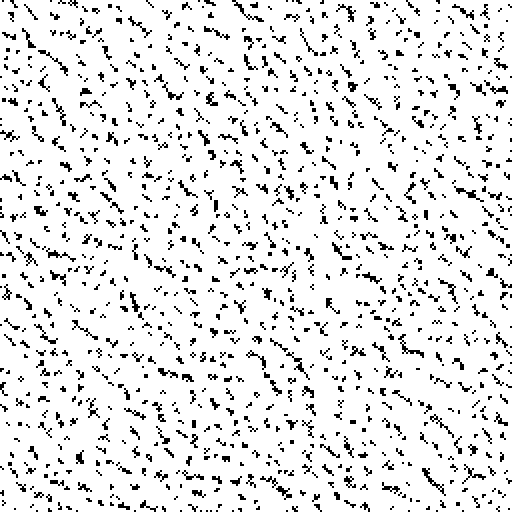

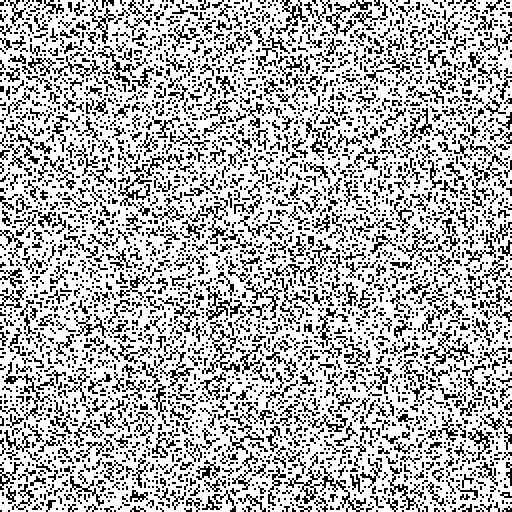

after_neighbor_1_function_1_density_3_size_256.png


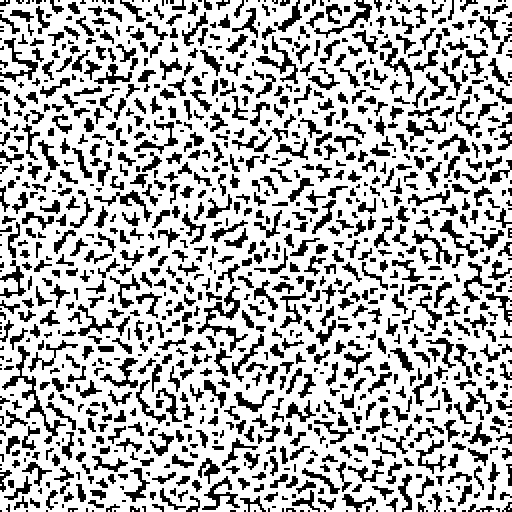



after_neighbor_1_function_5_density_3_size_256.png


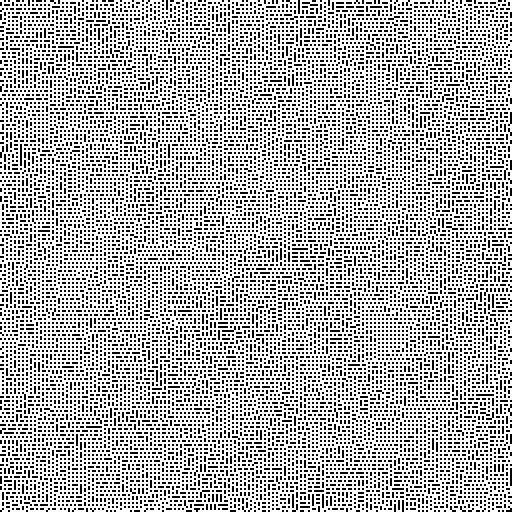



after_neighbor_1_function_6_density_3_size_256.png


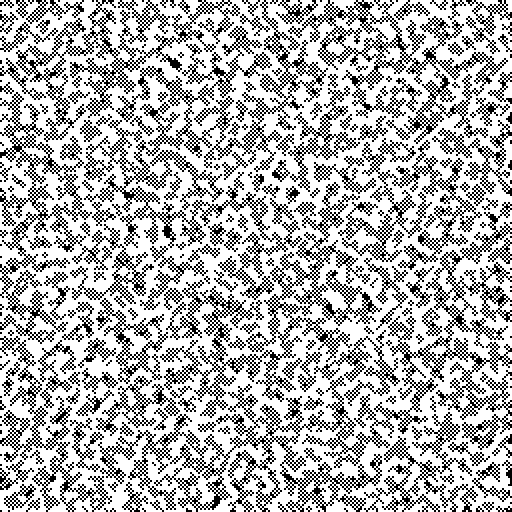



after_neighbor_1_function_7_density_3_size_256.png


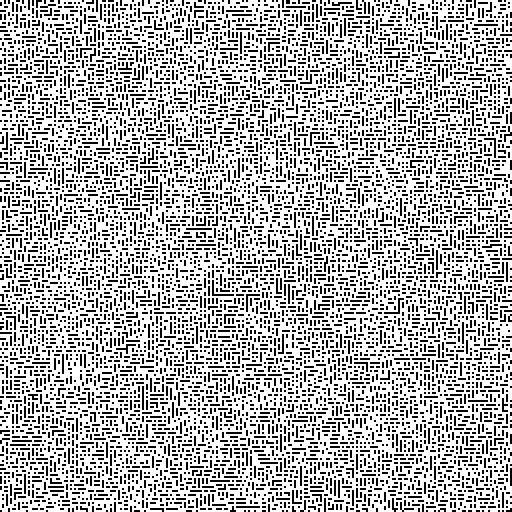



after_neighbor_2_function_5_density_3_size_256.png


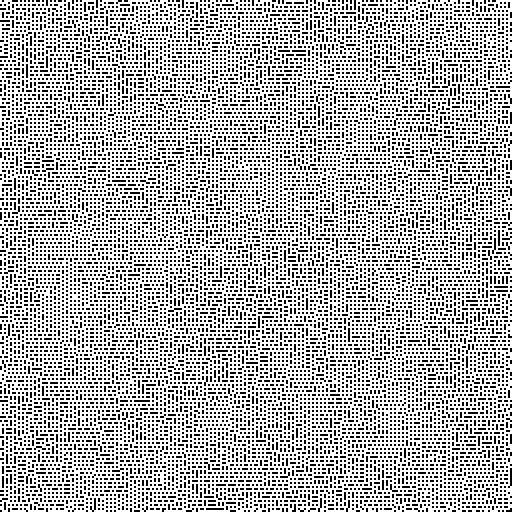



after_neighbor_3_function_4_density_3_size_256.png


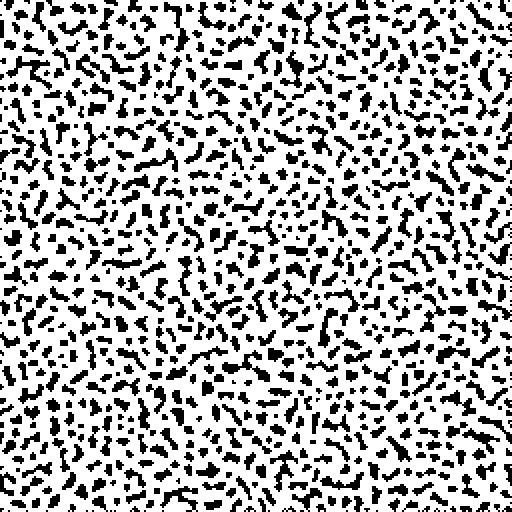



after_neighbor_4_function_2_density_3_size_256.png


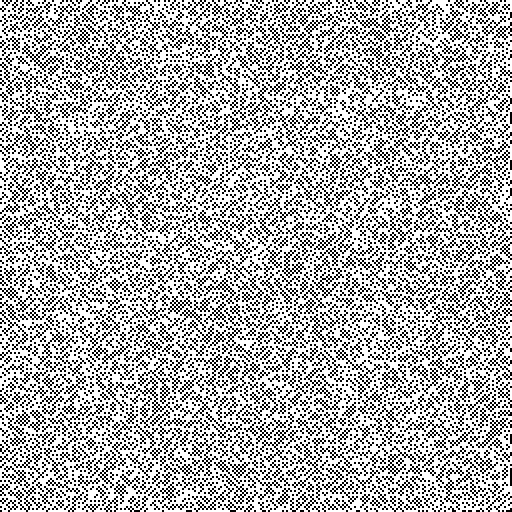



after_neighbor_5_function_7_density_3_size_256.png


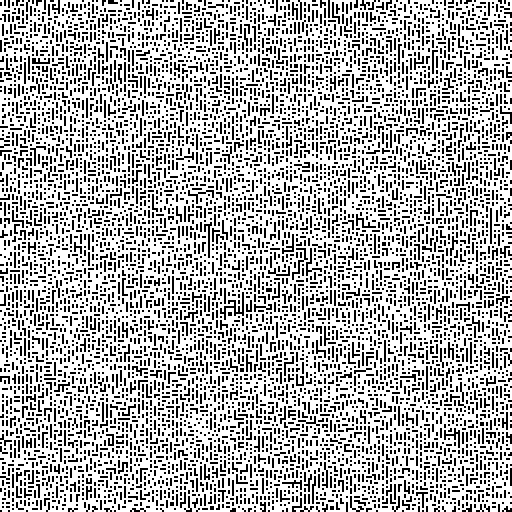



after_neighbor_6_function_4_density_3_size_256.png


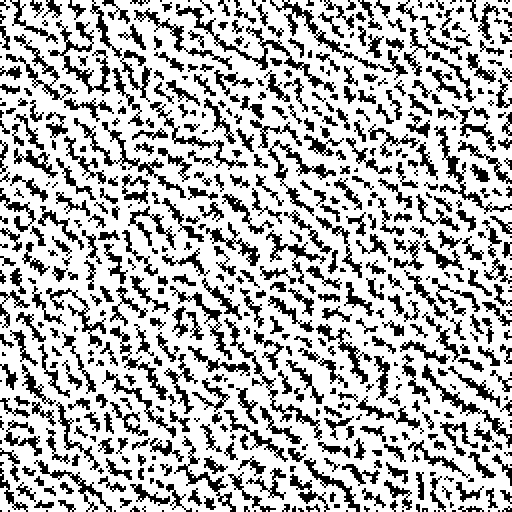

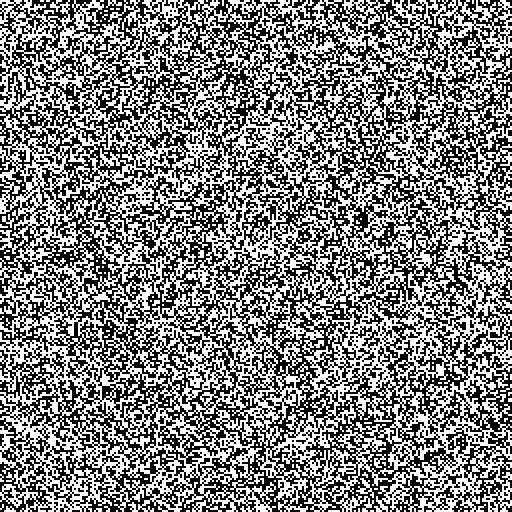

after_neighbor_1_function_1_density_5_size_256.png


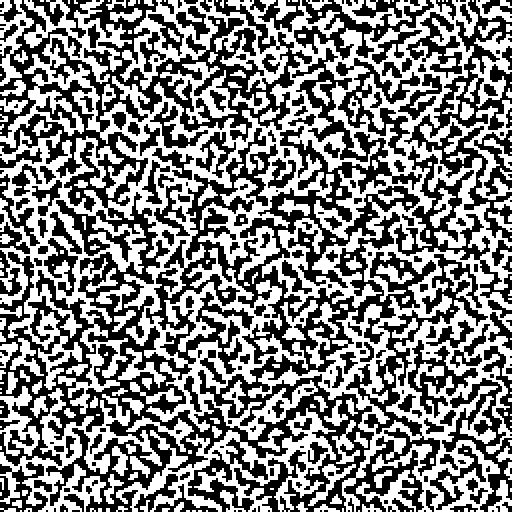



after_neighbor_1_function_5_density_5_size_256.png


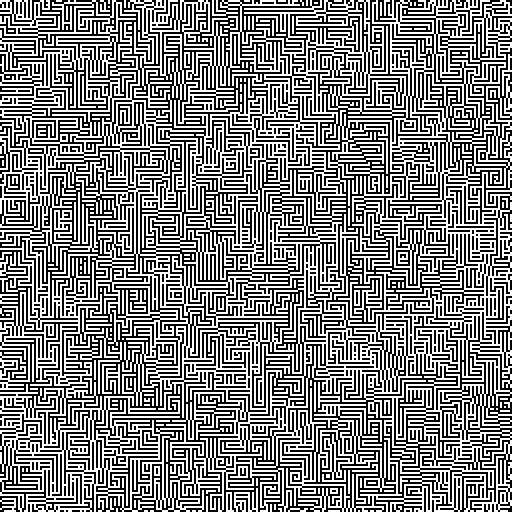



after_neighbor_1_function_6_density_5_size_256.png


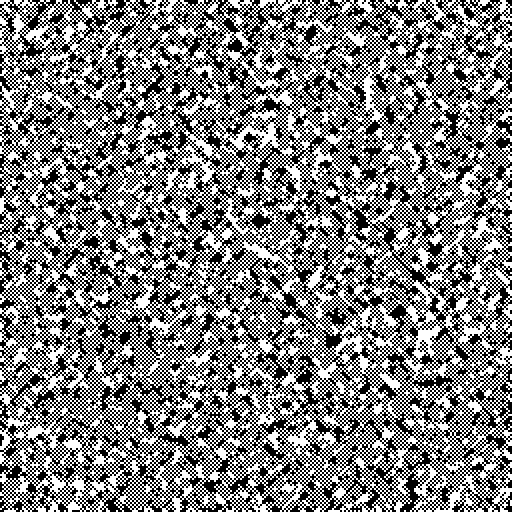



after_neighbor_1_function_7_density_5_size_256.png


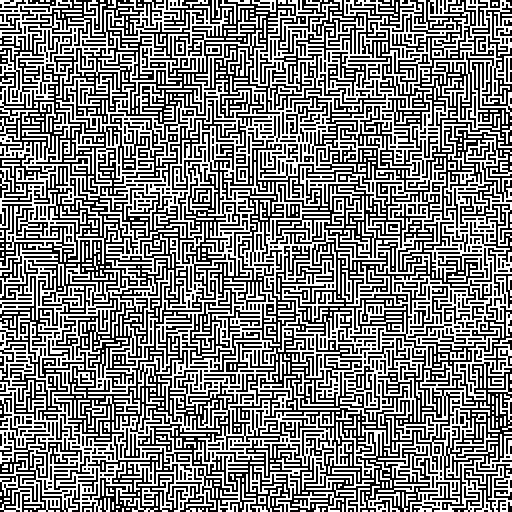



after_neighbor_2_function_5_density_5_size_256.png


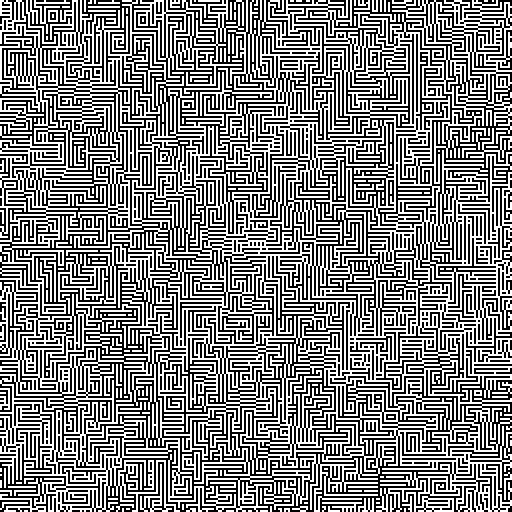



after_neighbor_3_function_4_density_5_size_256.png


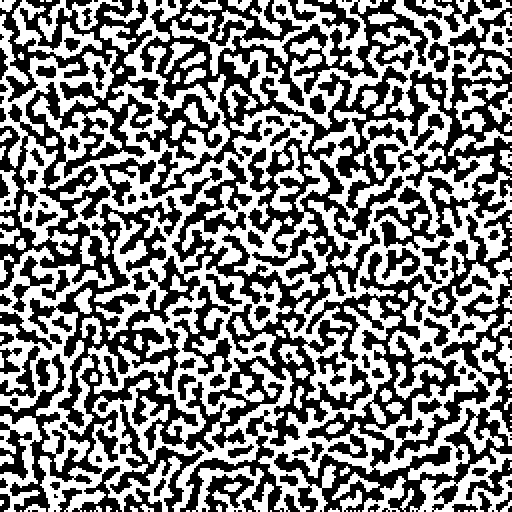



after_neighbor_4_function_2_density_5_size_256.png


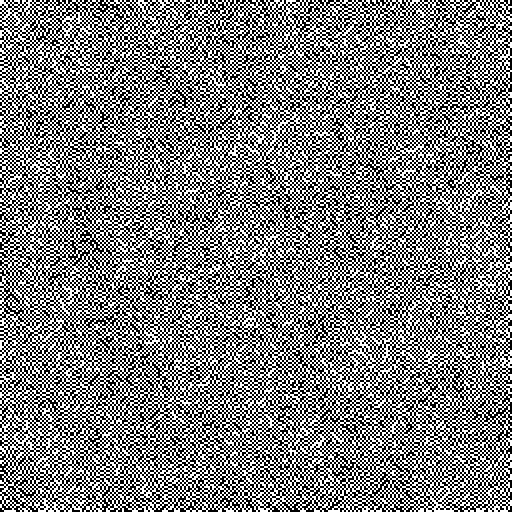



after_neighbor_5_function_7_density_5_size_256.png


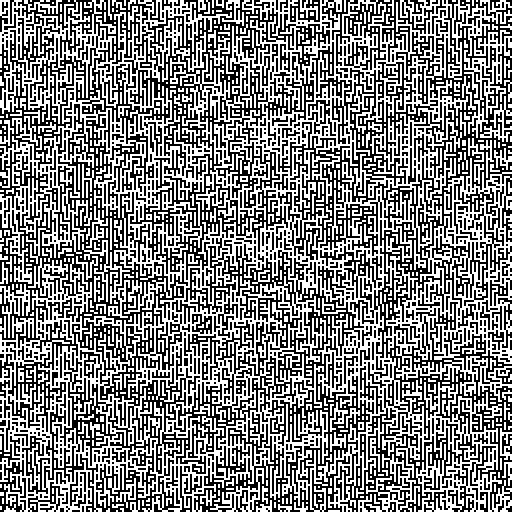



after_neighbor_6_function_4_density_5_size_256.png


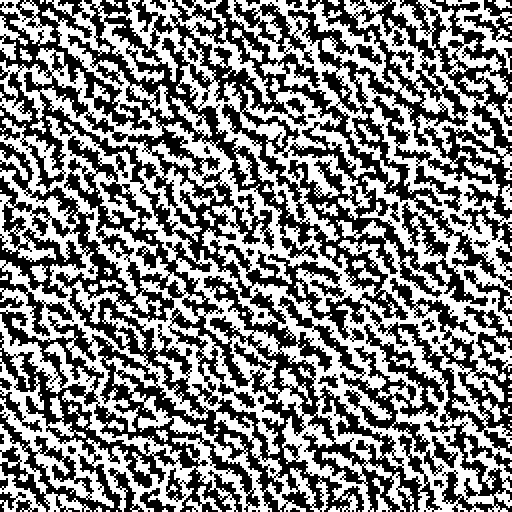

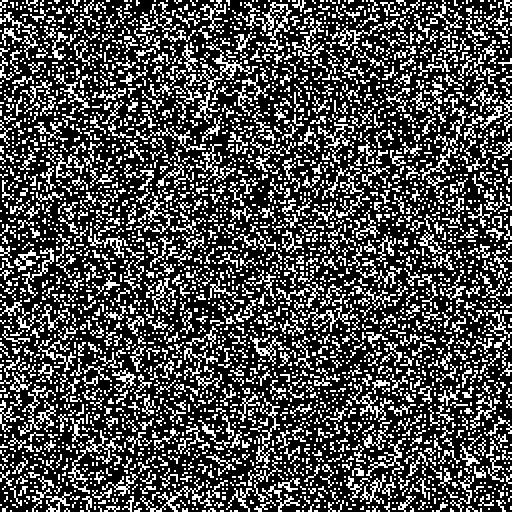

after_neighbor_1_function_1_density_7_size_256.png


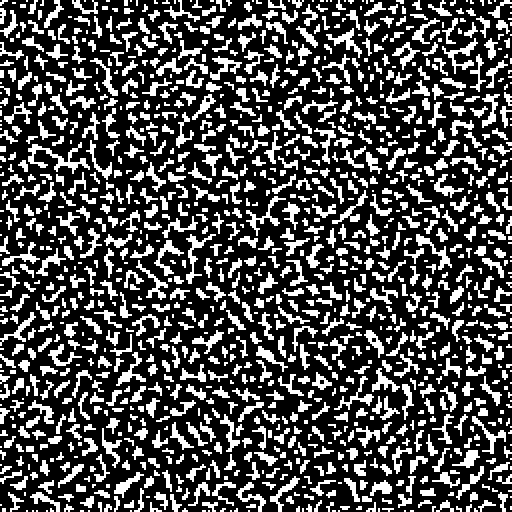



after_neighbor_1_function_5_density_7_size_256.png


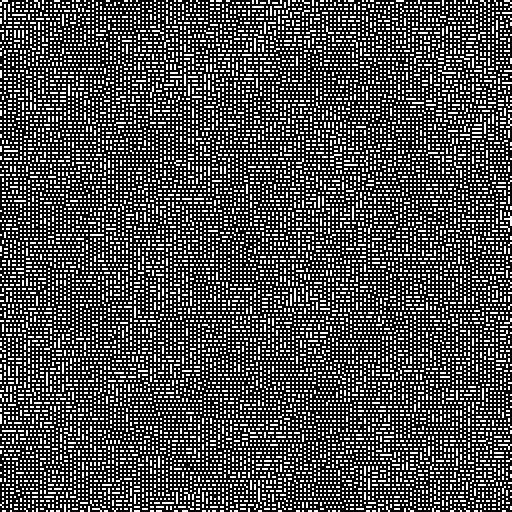



after_neighbor_1_function_6_density_7_size_256.png


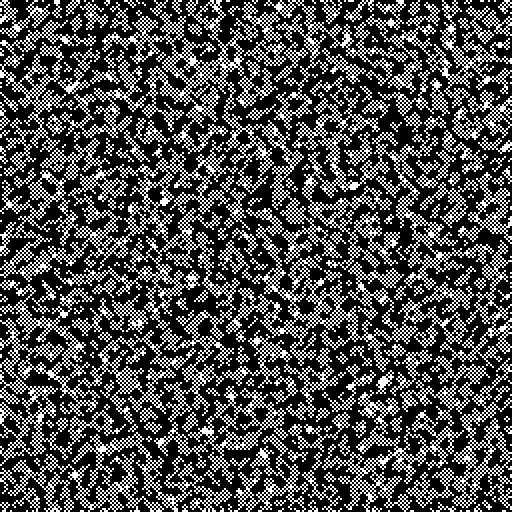



after_neighbor_1_function_7_density_7_size_256.png


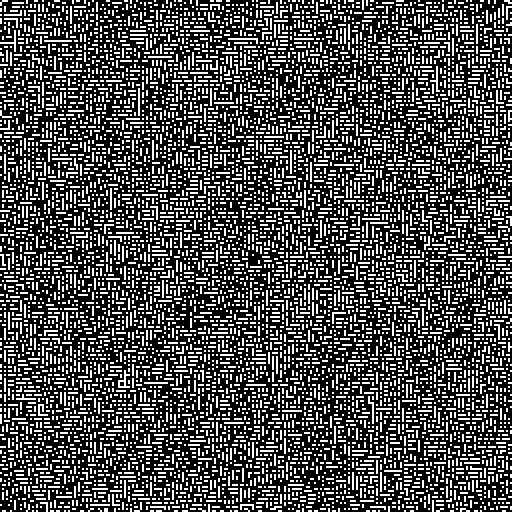



after_neighbor_2_function_5_density_7_size_256.png


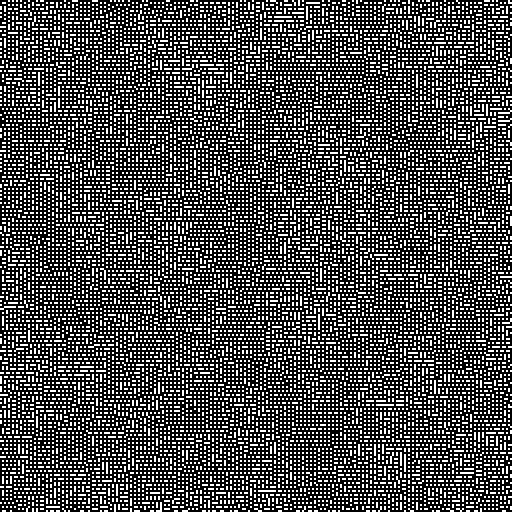



after_neighbor_3_function_4_density_7_size_256.png


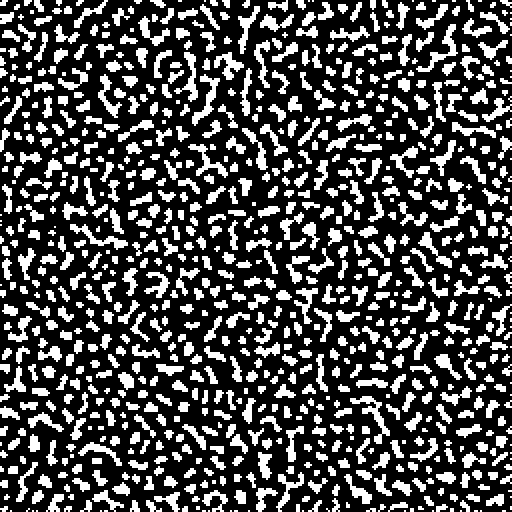



after_neighbor_4_function_2_density_7_size_256.png


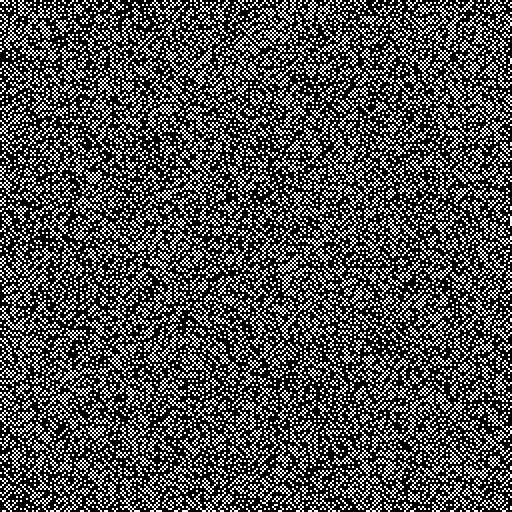



after_neighbor_5_function_7_density_7_size_256.png


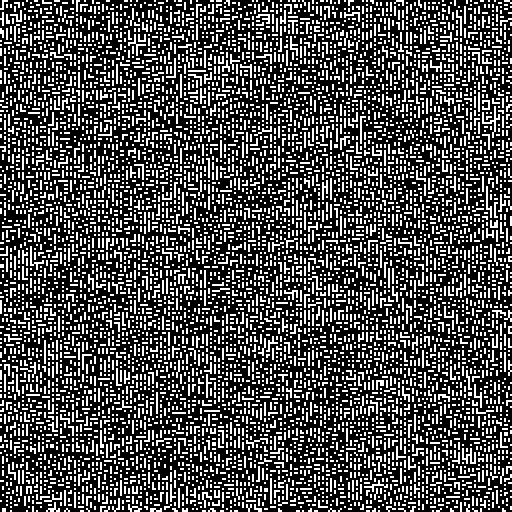



after_neighbor_6_function_4_density_7_size_256.png


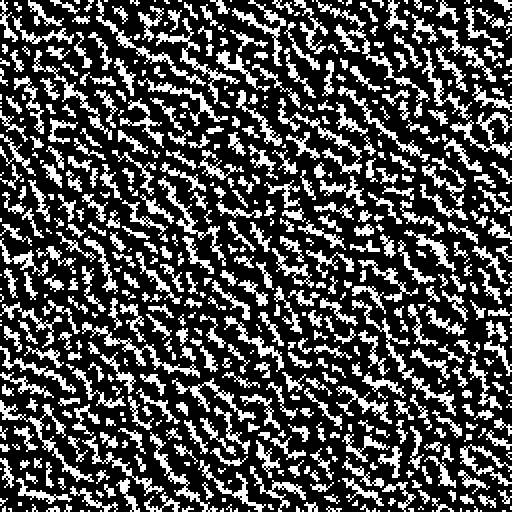

In [177]:
make_tests()